In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
import matplotlib.style as style 
style.use('tableau-colorblind10')

In [2]:
nburn = 10000  #step for equilibration
nstep = 50000  #step for simulation
nstp=(3000,3000)   #graphs will represent nstp[0] first and nstp[1] last steps
lab_state=['solid','liquid','gas']; title_burn=('First','Last')
title=['Potential energy','Pressure']

def graph_burn(meas, ifburn):   #meas is "energy" or "pres"
    label=lab_state.copy(); tit=title.copy()
    if ifburn:
        name='results_eq'; tit=', equilibration'
        head=(1,nburn-nstp[1]); max_r=(nstp[0],nburn)  #genfromtxt parameters
    else:
        name='results'; tit=', simulation'
        head=(1,nstep-nstp[1]); max_r=(nstp[0],nstep)
    
    pl.figure(figsize=(15,5))
    for i in range(2):
        obs_s=np.genfromtxt('build/ex07.1/solid/'+name+'/instant_'+meas+'.dat',skip_header=head[i],max_rows=max_r[i],names='x,u')
        obs_l=np.genfromtxt('build/ex07.1/liquid/'+name+'/instant_'+meas+'.dat',skip_header=head[i],max_rows=max_r[i],names='x,u')
        obs_g=np.genfromtxt('build/ex07.1/gas/'+name+'/instant_'+meas+'.dat',skip_header=head[i],max_rows=max_r[i],names='x,u')
        obs=(obs_s,obs_l,obs_g)
        p_rescale=(20.,12.,1.);    #scale factor for visually more clear graphs
        y_lab='$U$'
        if meas=="pres":
            for k in range(3): obs[k]['u']/=p_rescale[k]; label[k]=lab_state[k]+' (/'+str(int(p_rescale[k]))+')'
            y_lab='$P$'

        pl.subplot(1,2,i+1)
        for j in range(3): pl.plot(obs[j]['x'],obs[j]['u'],label=label[j])
        if meas=="epot": pl.ylim(-9,0)
        elif meas=="press": pl.ylim(-0.7,0.5)
        pl.legend(loc='best')
        pl.xlabel('$N_{stp}$')
        if i==0: pl.ylabel(y_lab,labelpad=15)
        pl.title(title_burn[i]+' '+str(nstp[i])+' points')
        pl.grid(True)
    
    if meas=="epot": pl.suptitle(title[0]+tit)
    elif meas=="press": pl.suptitle(title[1]+tit)
    pl.show()

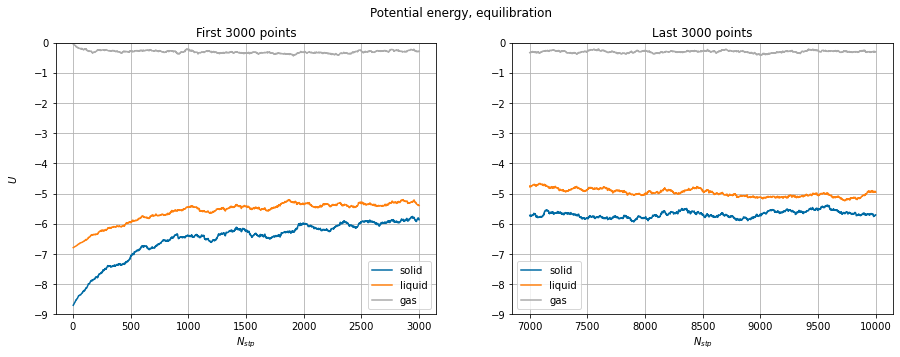

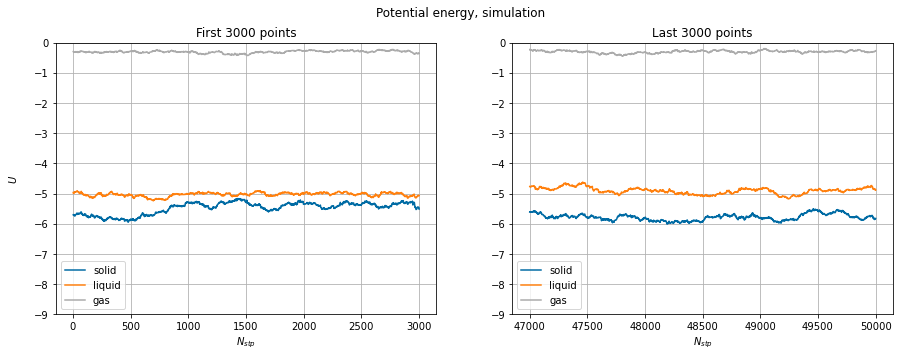

In [3]:
graph_burn("epot",True)
graph_burn("epot",False)

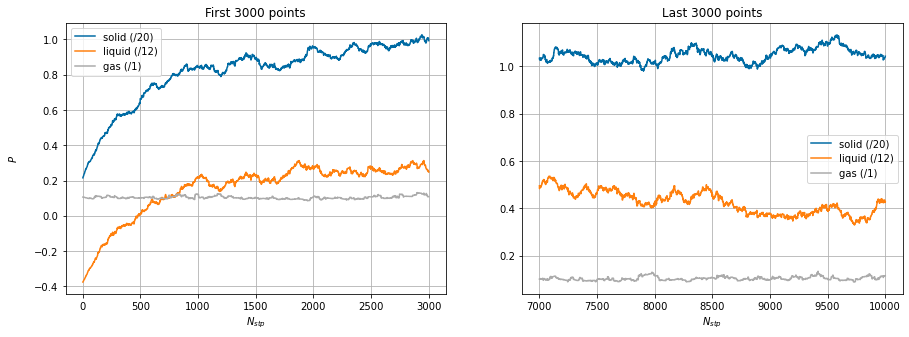

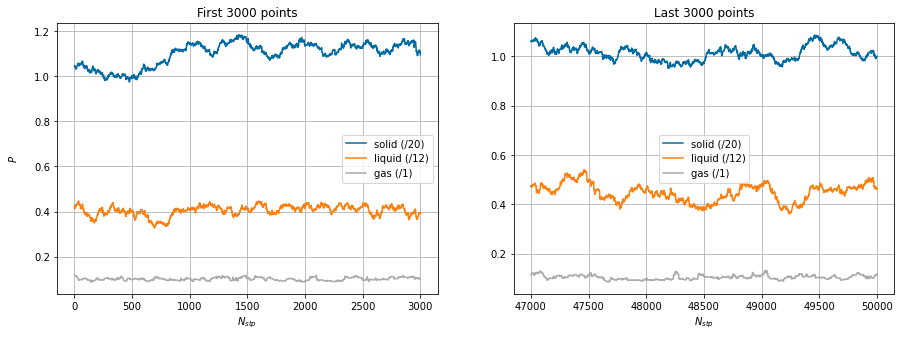

In [4]:
graph_burn("pres",True)
graph_burn("pres",False)

In [5]:
long=500           #t in graph, but I use tmax=20*long to reduce near tmax fluctuations (not all data for efficiency)
t,tmax=np.arange(long),20*long

def autocorr(state,meas):   #state can be "solid","liquid","gas"; meas can be "epot", "pres"
    data=np.genfromtxt('build/ex07.1/'+state+'/results/instant_'+meas+'.dat',max_rows=tmax,usecols=(1))
    summ=[np.zeros(long) for i in range(3)]
    summ[0]=[sum(data[0:tmax-tt]*data[tt:tmax]) for tt in t]
    summ[1]=[sum(data[0:tmax-tt]) for tt in t]
    summ[2]=[sum(data[tt:tmax]) for tt in t]
    for i in range(3): summ[i]/=tmax-t
    a=1./tmax*sum(data**2)-(1./tmax*sum(data))**2
    print("...", end=" ")
    return (summ[0]-summ[1]*summ[2])/a

In [6]:
print("computing energy autocorrelation...", end=" ")
Ac_ene=(autocorr('solid','epot'),autocorr('liquid','epot'),autocorr('gas','epot'))
print(); print("computing pressure autocorrelation...", end=" ")
Ac_pres=(autocorr('solid','pres'),autocorr('liquid','pres'),autocorr('gas','pres'))
Ac=(Ac_ene,Ac_pres)

computing energy autocorrelation... ... ... ... 
computing pressure autocorrelation... ... ... ... 

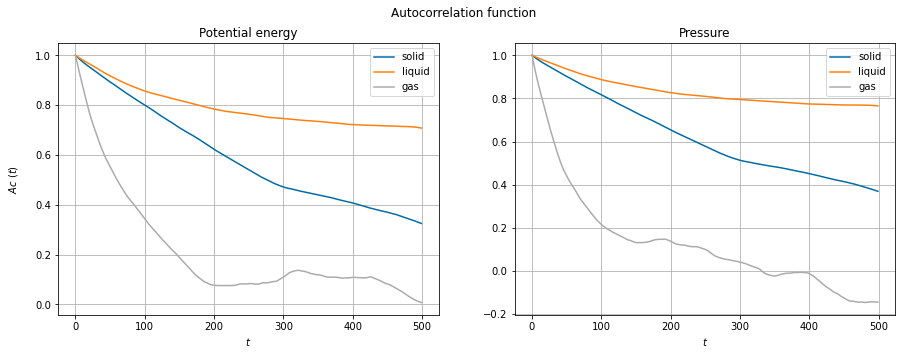

In [7]:
pl.figure(figsize=(15,5))
for i in range(2):
    pl.subplot(1,2,i+1)
    for j in range(3): pl.plot(t,Ac[i][j],label=lab_state[j])
    pl.legend(loc='best')
    pl.xlabel('$t$')
    if i==0: pl.ylabel('$Ac\ (t)$',labelpad=15)
    pl.title(title[i])
    pl.grid(True)
pl.suptitle('Autocorrelation function')
pl.show()

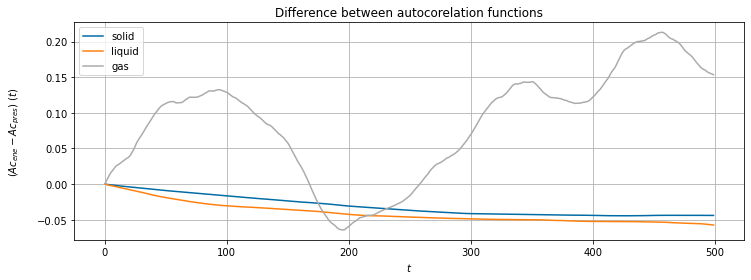

In [8]:
pl.figure(figsize=(12,4))
for j in range(3): pl.plot(t,Ac[0][j]-Ac[1][j],label=lab_state[j])
pl.legend(loc='best')
pl.xlabel('$t$')
pl.ylabel('$(Ac_{ene}-Ac_{pres})\ (t)$',labelpad=15)
pl.title('Difference between autocorelation functions')
pl.grid(True)
pl.show()

In [9]:
def autocorrelation(observable):
    #initialize vector
    auto=np.zeros(len(observable))
    #compute denominator
    tot=np.sum(observable)
    #is it right? t from zero to len-1?
    tmax=len(observable)-1
    #global normalization factor
    norm=np.dot(observable, observable)/tmax-tot*tot/(tmax*tmax)
    cumsum=np.cumsum(observable)
    for i in range( len(observable)-1): #if arrive to len(obs) a division by zero occours
        norm2=tmax-i #normalization factor at the numerator
        a=np.dot(observable[:tmax-i+1], observable[i:])            
        auto[i]=a/norm2-(cumsum[tmax-i]*(tot-cumsum[i]))/(norm2*norm2)
    #arbitrary set correlation a tmax = 0 (auto has been initialized to all zeros, and i am not setting the last
    #component)
    return auto/norm


def last_blocking_error(observable, per_block):
    n_blocks=int(len(observable)/per_block)
    blocks=np.zeros(n_blocks)
    for i in range(n_blocks):
        blocks[i]=np.sum(observable[i*per_block:(i+1)*per_block])
    blocks/=per_block
    blocks2=np.multiply(blocks, blocks)
    
    blocks=np.sum(blocks)
    blocks2=np.sum(blocks2)
    err=np.sqrt((blocks2/n_blocks - np.power(blocks/n_blocks,2))/(n_blocks-1))
        
    return err

In [10]:
def blocking_error(state, meas):
    instant = np.loadtxt('build/ex07.1/'+state+'/results/instant_'+meas+ '.dat',usecols=(1))
    correlation = autocorrelation(instant)
    err=[]
    value=[]
    blk_size=[]
    for i in range (10, 100,10):
        blk_size.append(i)
        err.append(last_blocking_error(instant, i))
    for i in range (50, 5000,50):
        blk_size.append(i)
        err.append(last_blocking_error(instant, i))
    grap=[blk_size, err]
    return grap

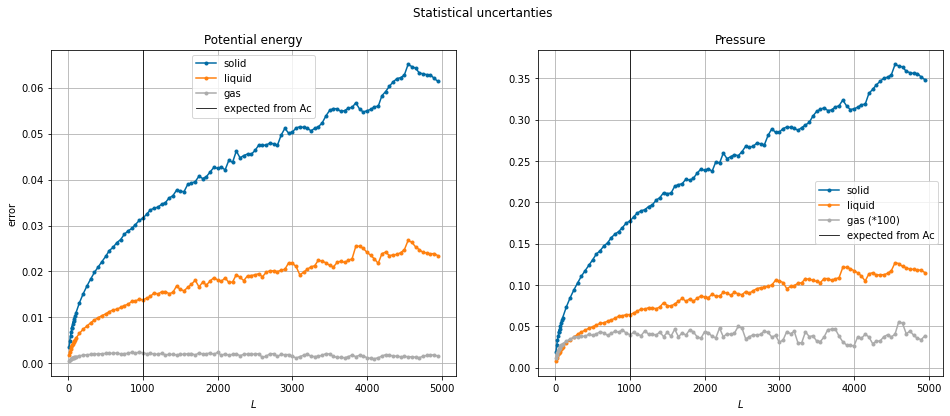

In [11]:
esol = blocking_error('solid', 'epot')
eliq = blocking_error('liquid', 'epot')
egas = blocking_error('gas', 'epot')
psol = blocking_error('solid', 'pres')
pliq = blocking_error('liquid', 'pres')
pgas = blocking_error('gas', 'pres')
pgass = [100*x for x in pgas[1]]

pl.figure(figsize=(16,6))
pl.subplot(1,2,1)
pl.plot(esol[0], esol[1], marker='.', label='solid')
pl.plot(eliq[0], eliq[1], marker='.', label='liquid')
pl.plot(egas[0], egas[1], marker='.', label='gas')
pl.axvline(x=1000,color='k',linewidth=0.8,label='expected from Ac')
pl.grid(True)
pl.ylabel('error')
pl.title('Potential energy')
pl.legend(loc='best')
pl.xlabel('$L$')
pl.subplot(1,2,2)
pl.plot(psol[0], psol[1], marker='.', label='solid')
pl.plot(pliq[0], pliq[1], marker='.', label='liquid')
pl.plot(pgas[0], pgass, marker='.', label='gas (*100)')
pl.axvline(x=1000,color='k',linewidth=0.8,label='expected from Ac')
pl.legend(loc='best')
pl.xlabel('$L$')
pl.grid(True)
pl.title('Pressure')
pl.suptitle('Statistical uncertanties', )
pl.show()

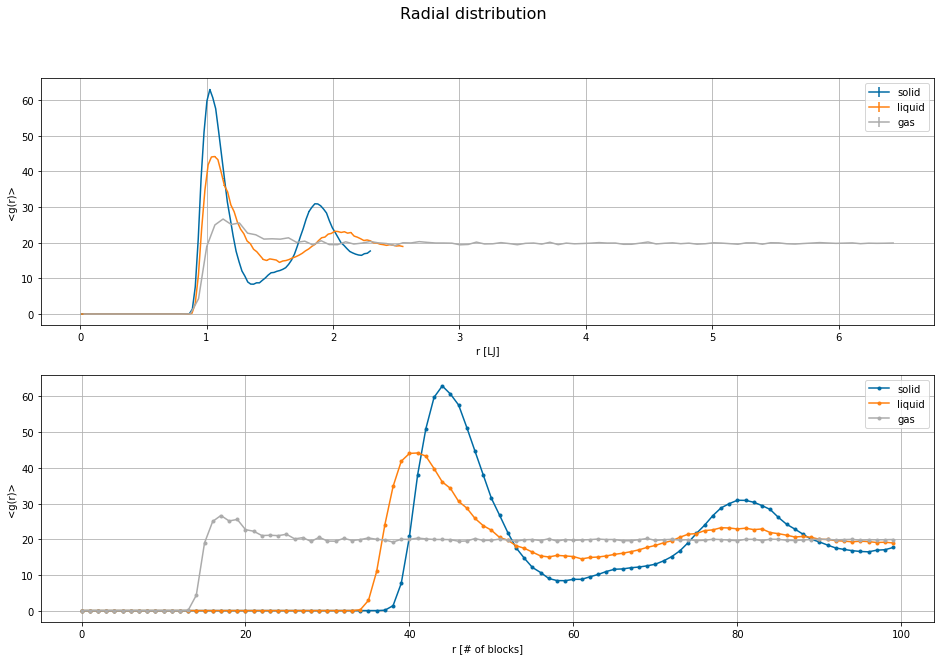

In [12]:
pl.figure(figsize=(16,10))

for k in range (2):
    pl.subplot(2,1,k+1) 
    for state in lab_state:
        g = np.loadtxt('build/ex07.2/'+ state + '/results/gave.dat')
        r = np.loadtxt('build/ex07.2/' + state + '/results/binning.dat')
        g_err = np.loadtxt('build/ex07.2/' + state + '/results/gerr.dat')    
        if k==0: 
            pl.errorbar(r[-1],g[-1],yerr=g_err[-1], label=state)
            pl.xlabel("r [LJ]")
        else: 
            pl.plot(g[-1], label=state, marker='.')
            pl.xlabel("r [# of blocks]")

    pl.legend(loc='best')
    pl.grid(True)
    pl.ylabel("<g(r)>")
pl.suptitle("Radial distribution", size='16')
pl.show()

In [13]:
#costants for conversion between LJ units and SI units
sig=0.34                            #sigma [nm]
kB,eps_kB=1.98064852e-23,120.       #Boltzmann constant [J/K], eps/kB [K]
eps=eps_kB*kB;                      #eps [J]

EpotS=np.genfromtxt('build/ex07.2/solid/results/epot.dat',usecols=(0,2,3),names='nblk,res,err')
EpotL=np.genfromtxt('build/ex07.2/liquid/results/epot.dat',usecols=(0,2,3),names='nblk,res,err')
EpotG=np.genfromtxt('build/ex07.2/gas/results/epot.dat',usecols=(0,2,3),names='nblk,res,err')
PS=np.genfromtxt('build/ex07.2/solid/results/pres.dat',usecols=(0,2,3),names='nblk,res,err')
PL=np.genfromtxt('build/ex07.2/liquid/results/pres.dat',usecols=(0,2,3),names='nblk,res,err')
PG=np.genfromtxt('build/ex07.2/gas/results/pres.dat',usecols=(0,2,3),names='nblk,res,err')
obs=(EpotS,PS,EpotL,PL,EpotG,PG)

for i in range(6):
    obs[i]['res']*=eps; obs[i]['err']*=eps    #energy conversion
    if i%2==1: obs[i]['res']*=1e18/(sig**3); obs[i]['err']*=1e18/(sig**3) #pressure conversion


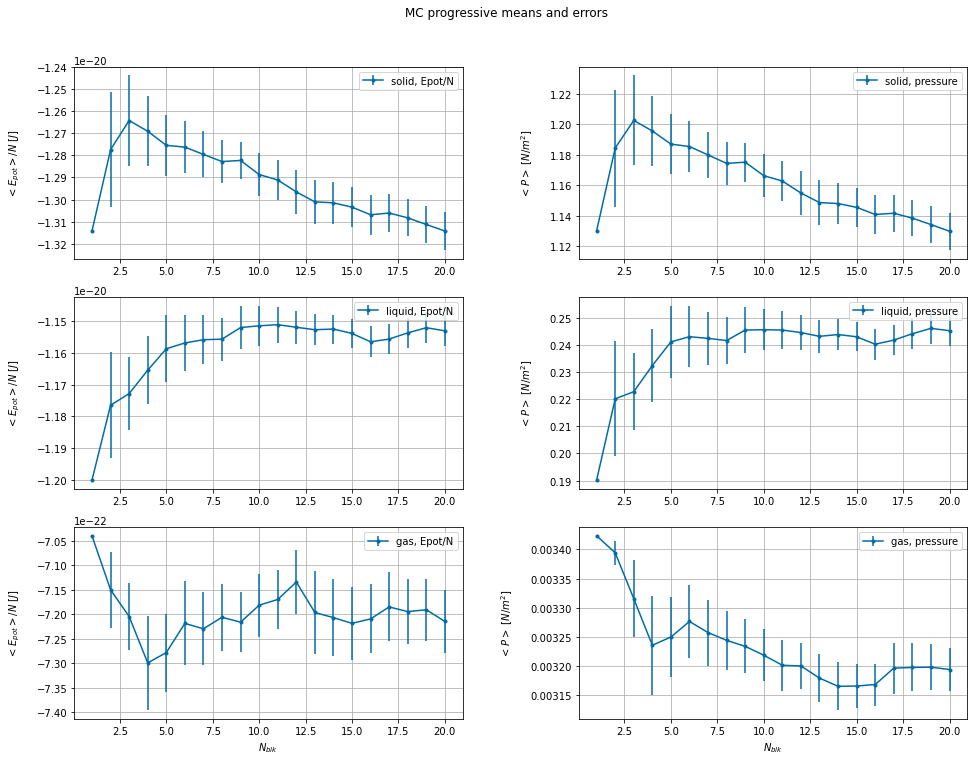

In [14]:
obs_label=(', Epot/N',', pressure'); y_lab=['$<E_{pot}>/N\ [J]$','$<P>\ [N/m^2]$']

pl.figure(figsize=(16,12))
for i in range(6):
    pl.subplot(3,2,i+1)
    pl.errorbar(obs[i]['nblk'],obs[i]['res'],yerr=obs[i]['err'],marker='.',label=lab_state[i//2]+obs_label[i%2])
    pl.legend(loc='best')
    if i>3: pl.xlabel('$N_{blk}$')
    pl.ylabel(y_lab[i%2],labelpad=15)
    pl.grid(True)
pl.suptitle("MC progressive means and errors", y=0.95)
pl.subplots_adjust(wspace=0.3)
pl.show()